In [1]:
import os, sys, glob
import math
import numpy as np
import pandas as pd
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
mpl.rc('text', usetex=True)
sns.set_context("notebook", font_scale=1.75)

# 1. TRACERx lung

In [32]:
df = pd.read_csv("tracerx_WES.tsv", sep="\t")

In [33]:
df['norm_RSS'] = np.sqrt(df['RSS']) / (96*df['n'])

In [34]:
def identifyMinBIC(df, patient, tree_idx):
    k = int(df.iloc[df[(df['patient'] == patient) & (df['tree'] == tree_idx)]['BIC'].idxmin()]['k'])
    BIC = df[(df['patient'] == patient) & (df['tree'] == tree_idx)]['BIC'].min()
    RSS = df[(df['patient'] == patient) & (df['tree'] == tree_idx) & (df['k'] == k)]['RSS'].iloc[0]
    norm_RSS = df[(df['patient'] == patient) & (df['tree'] == tree_idx) & (df['k'] == k)]['norm_RSS'].iloc[0]
    return int(k), float(BIC), float(RSS), float(norm_RSS)

In [35]:
df['dRSS'] = 0.
df['rRSS'] = 1.
df['BIC_pref'] = False
df['max_k'] = False
for patient in set(df['patient']):
    for tree_idx in set(df[(df['patient'] == patient)]['tree']):
        k, BIC, RSS, norm_RSS = identifyMinBIC(df, patient, tree_idx)
        K = set(df[(df['patient'] == patient) & (df['tree'] == tree_idx)]['k'])
        max_k = max(K)
        for kk in K:
            idx = df[(df['patient'] == patient) & (df['tree'] == tree_idx) & (df['k'] == kk)]['BIC'].idxmin()
            RSS_kk = float(df.iloc[idx]['RSS'])
            norm_RSS_kk = float(df.iloc[idx]['norm_RSS'])
            df.at[idx, 'dRSS'] = RSS_kk - RSS
            df.at[idx, 'rRSS'] = RSS_kk / RSS
            df.at[idx, 'd_norm_RSS'] = norm_RSS_kk - norm_RSS
            df.at[idx, 'r_norm_RSS'] = norm_RSS_kk / norm_RSS
            df.at[idx, 'BIC_pref'] = kk == k
            df.at[idx, 'max_k'] = kk == max_k

In [63]:
df[df["BIC_pref"]].RSS.median()

1147.816

In [37]:
with open("tracerx_sum_WES.tsv", "w") as f:
    f.write("\t".join(["patient", "n", "tree", "k", 
                       "min_mut", "max_mut", "RSS", "method"]) + "\n")
    for patient in set(df['patient']):
        for tree_idx in set(df[(df['patient'] == patient)]['tree']):
            K = set(df[(df['patient'] == patient) & (df['tree'] == tree_idx)]['k'])
            n = int(df[(df['patient'] == patient) & (df['tree'] == tree_idx) & (df['k'] == 0)]['n'].iloc[0])
            max_k = max(K)
            f.write("\t".join(map(str, [patient, 
                                        n, 
                                        tree_idx, 
                                        0, 
                                        int(df[(df['patient'] == patient) & 
                                               (df['tree'] == tree_idx) & 
                                               (df['k'] == 0)]['min_mut'].iloc[0]),
                                        int(df[(df['patient'] == patient) & 
                                               (df['tree'] == tree_idx) & 
                                               (df['k'] == 0)]['max_mut'].iloc[0]),
                                        float(df[(df['patient'] == patient) & 
                                                  (df['tree'] == tree_idx) & 
                                                  (df['k'] == 0)]['RSS'].iloc[0]),
                                        "min-k"
                                       ])) + "\n")
            f.write("\t".join(map(str, [patient, 
                                        n, 
                                        tree_idx, 
                                        max_k, 
                                        int(df[(df['patient'] == patient) & 
                                               (df['tree'] == tree_idx) & 
                                               (df['k'] == max_k)]['min_mut'].iloc[0]),
                                        int(df[(df['patient'] == patient) & 
                                               (df['tree'] == tree_idx) & 
                                               (df['k'] == max_k)]['max_mut'].iloc[0]),
                                        float(df[(df['patient'] == patient) & 
                                                 (df['tree'] == tree_idx) & 
                                                 (df['k'] == max_k)]['RSS'].iloc[0]),
                                        "max-k"
                                       ])) + "\n")
            f.write("\t".join(map(str, [patient, 
                                        n, 
                                        tree_idx, 
                                        int(df[(df['patient'] == patient) & 
                                             (df['tree'] == tree_idx) & 
                                             (df['BIC_pref'])]['k'].iloc[0]),
                                        int(df[(df['patient'] == patient) & 
                                               (df['tree'] == tree_idx) & 
                                               (df['BIC_pref'])]['min_mut'].iloc[0]),
                                        int(df[(df['patient'] == patient) & 
                                               (df['tree'] == tree_idx) & 
                                               (df['BIC_pref'])]['max_mut'].iloc[0]),
                                        float(df[(df['patient'] == patient) & 
                                               (df['tree'] == tree_idx) & 
                                               (df['BIC_pref'])]['RSS'].iloc[0]),
                                        "BIC-k"
                                       ])) + "\n")

In [38]:
df2 = pd.read_csv("tracerx_sum_WES.tsv", sep="\t")

In [39]:
df2['norm_RSS'] = np.sqrt(df2['RSS']) / (96*df2['n'])

In [40]:
df2['sqrt_RSS'] = np.sqrt(df2['RSS'])

In [41]:
df2['edges'] = df2['n'] - 1

In [69]:
patients = set(df2[(df2["k"] > 0) & (df2["method"] == "BIC-k")].patient)

In [72]:
df2[df2["patient"].isin(patients)]

,patient,n,tree,k,min_mut,max_mut,RSS,method,norm_RSS,sqrt_RSS,edges
60,CRUK0075,3,1,0,893,893,4377.4690,min-k,0.229731,66.162444,2
61,CRUK0075,3,1,2,82,670,3047.0530,max-k,0.191667,55.200118,2
62,CRUK0075,3,1,1,141,752,3166.1320,BIC-k,0.195376,56.268393,2
114,CRUK0069,12,1,0,876,876,3073.6700,min-k,0.048126,55.440689,11
115,CRUK0069,12,1,11,11,584,2863.8670,max-k,0.046454,53.515110,11
116,CRUK0069,12,1,1,220,656,2917.2200,BIC-k,0.046885,54.011295,11
117,CRUK0068,10,1,0,865,865,2950.6380,min-k,0.056583,54.319775,9
118,CRUK0068,10,1,9,11,500,2479.7720,max-k,0.051872,49.797309,9
119,CRUK0068,10,1,1,143,722,2648.2070,BIC-k,0.053605,51.460733,9
120,CRUK0068,10,2,0,865,865,2950.6380,min-k,0.056583,54.319775,9


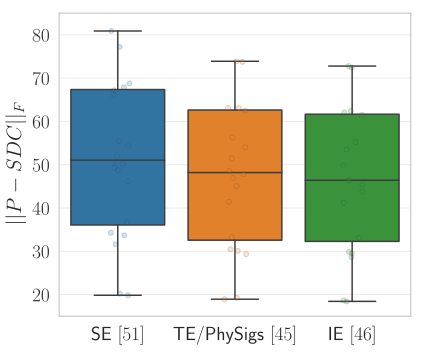

In [130]:
g = sns.boxplot(data=df2[(df2["patient"].isin(patients)) & (df2["tree"]==1)], x="method", y="sqrt_RSS", order=["min-k", "BIC-k", "max-k"], showfliers=False)
sns.stripplot(data=df2[(df2["patient"].isin(patients))  & (df2["tree"]==1)], x="method", y="sqrt_RSS", order=["min-k", "BIC-k", "max-k"], jitter=.1, alpha=.2, lw=1)
g.set_ylim((15,85))
# g.set_yscale("log")
g.grid(which='both', axis='y', alpha=.4)
g.set_ylabel("$||P-SDC||_F$")
g.set_xlabel("")
g.set_xticklabels(["SE $[" + str(int(round(np.median(df2[(df2["patient"].isin(patients)) & (df2["tree"]==1) & (df2['method'] == "min-k")].sqrt_RSS), 0))) + "]$", 
                   "TE/PhySigs $[" + str(int(round(np.median(df2[(df2["patient"].isin(patients)) & (df2['method'] == "BIC-k")].sqrt_RSS), 0))) + "]$", 
                   "IE $[" + str(int(round(np.median(df2[(df2["patient"].isin(patients)) & (df2["tree"]==1) & (df2['method'] == "max-k")].sqrt_RSS), 0))) + "]$"])
plt.gcf().set_size_inches(6, 5)
plt.tight_layout()
plt.savefig("tracerx_RSS.pdf")

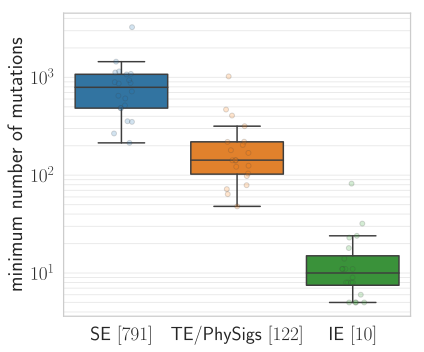

In [131]:
g = sns.boxplot(data=df2[(df2["patient"].isin(patients) & (df2["tree"]==1))], x="method", y="min_mut", order=["min-k", "BIC-k", "max-k"], showfliers=False)
sns.stripplot(data=df2[(df2["patient"].isin(patients)) & (df2["tree"]==1)], x="method", y="min_mut", order=["min-k", "BIC-k", "max-k"], jitter=.1, alpha=.2, lw=1)
# g.set_ylim((0,1500))
g.set_yscale("log")
g.grid(which='both', axis='y', alpha=.4)
g.set_ylabel("minimum number of mutations")
g.set_xlabel("")
g.set_xticklabels(["SE $[" + str(int(np.median(df2[(df2["patient"].isin(patients)) & (df2["tree"]==1) & (df2['method'] == "min-k")].min_mut))) + "]$", 
                   "TE/PhySigs $[" + str(int(np.median(df2[(df2["patient"].isin(patients)) & (df2['method'] == "BIC-k")].min_mut))) + "]$", 
                   "IE $[" + str(int(np.median(df2[(df2["patient"].isin(patients)) & (df2["tree"]==1) & (df2['method'] == "max-k")].min_mut))) + "]$"])
plt.gcf().set_size_inches(6, 5) 
plt.tight_layout()
plt.savefig("tracerx_min_mut.pdf")

In [55]:
len(df2[(df2["method"] == "BIC-k") & (df2["k"]==2)])

5

In [56]:
set(df2.n)

{2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15}

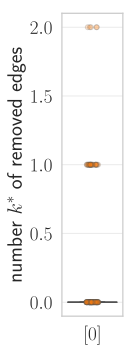

In [43]:
g = sns.boxplot(data=df2[df2['n']>0], x="method", y="k", order=["BIC-k"], showfliers=False, 
                color=sns.color_palette()[1])
sns.stripplot(data=df2[df2['n']>0], x="method", y="k", order=["BIC-k"], jitter=.1, 
              alpha=.2, lw=1, color=sns.color_palette()[1])
# g.set_ylim((-0.5,17))
# g.set_yscale("log")
g.grid(which='both', axis='y', alpha=.4)
g.set_ylabel("number $k^*$ of removed edges")
g.set_xlabel("")
g.set_xticklabels([])
g.set_xticklabels(["$[" + str(int(np.median(df2[df2['method'] == "BIC-k"].k))) + "]$"])
plt.gcf().set_size_inches(2, 5) 
plt.tight_layout()
plt.savefig("tracerx_kstar.pdf")

In [132]:
df2_count = df2[(df2["method"]=="BIC-k") & (df2["tree"]==1)].groupby(["k"]).count()["patient"].to_frame().rename(columns={"patient":"count"}).reset_index()

In [133]:
int(df2_count[df2_count["k"]==0]["count"])

71

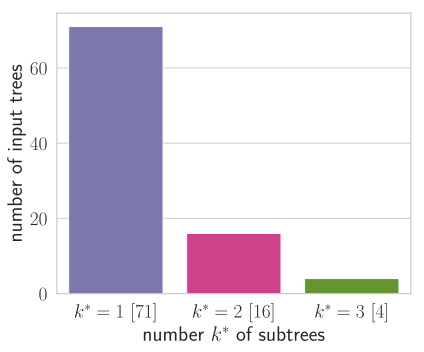

In [134]:
g = sns.barplot(data=df2_count, x="k", y="count", palette = sns.color_palette("Dark2")[2:])
g.set_ylabel("number of input trees")
g.set_xlabel("number $k^*$ of subtrees")
g.set_xticklabels(["$k^*=1$ $[" + str(int(df2_count[df2_count["k"]==0]["count"])) + "]$", 
                   "$k^*=2$ $[" + str(int(df2_count[df2_count["k"]==1]["count"])) + "]$", 
                   "$k^*=3$ $[" + str(int(df2_count[df2_count["k"]==2]["count"])) + "]$"])
plt.gcf().set_size_inches(6, 5)
plt.tight_layout()
plt.savefig("tracerx_kstar.pdf")

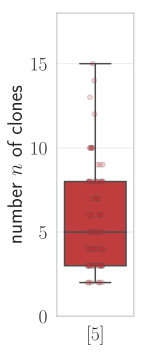

In [135]:
g = sns.boxplot(data=df2[(df2["tree"]==1)], x="method", y="n", order=["BIC-k"], showfliers=False, 
                color=sns.color_palette()[3])
sns.stripplot(data=df2[(df2["tree"]==1)], x="method", y="n", order=["BIC-k"], jitter=.1, 
              alpha=.2, lw=1, color=sns.color_palette()[3])
g.grid(which='both', axis='y', alpha=.4)
g.set_ylim((0,18))
g.set_ylabel("number $n$ of clones")
g.set_xlabel("")
g.set_xticklabels(["$[" + str(int(np.median(df2[(df2['method'] == "BIC-k") & (df2["tree"]==1)].n))) + "]$"])
plt.gcf().set_size_inches(2.15, 5)
plt.tight_layout()
plt.savefig("tracerx_nodes.pdf")

In [19]:
len(df2[df2['method'] == 'BIC-k'])

143

In [20]:
len(set(df2.patient))

91

In [21]:
max(df2.n)

15

# 2. Simulations

In [106]:
df_sims_opt = pd.read_csv("sims_opt.tsv", sep="\t")

In [107]:
df_sims = pd.read_csv("sims.tsv", sep="\t")

In [108]:
df_sims.head()

,instance,n,k,min_mut,max_mut,RSS,BIC
0,m5_S18_k0_eps0.1.P_eps.txt,5,0,inf,-inf,44.06565,-961.0771
1,m5_S18_k0_eps0.1.P_eps.txt,5,1,inf,-inf,42.20549,-796.5661
2,m5_S18_k0_eps0.1.P_eps.txt,5,2,inf,-inf,40.74117,-628.3018
3,m5_S18_k0_eps0.1.P_eps.txt,5,3,inf,-inf,38.99940,-464.0608
4,m5_S18_k0_eps0.1.P_eps.txt,5,4,inf,-inf,38.27194,-287.8852


In [109]:
df_sims_opt.head()

,instance,n,subtree,mutation_count,RSS,Signature.1,Signature.2,Signature.3,Signature.4,Signature.5,...,Signature.21,Signature.22,Signature.23,Signature.24,Signature.25,Signature.26,Signature.27,Signature.28,Signature.29,Signature.30
0,m5_S18_k0_eps0.1.P_eps.txt,5,1;3;2;5;4,659,44.06565,0.001902,0.000000,0.0,0.457186,0.068349,...,0.000000,0.000000,0.000000,0.002756,0.013766,0.000000,0.164707,0.000000,0.000000,0.056525
1,m5_S18_k0_eps0.2.P_eps.txt,5,1;3;2;5;4,363,53.07120,0.010439,0.000000,0.0,0.000000,0.047381,...,0.107914,0.140581,0.013719,0.000000,0.014851,0.067538,0.024911,0.182882,0.056951,0.000000
2,m5_S18_k0_eps0.3.P_eps.txt,5,1;3;2;5;4,484,78.89198,0.016956,0.004805,0.0,0.157055,0.000000,...,0.001903,0.005259,0.000000,0.153747,0.000000,0.000000,0.000000,0.000000,0.007980,0.019152
3,m5_S18_k1_eps0.1.P_eps.txt,5,1;3;2,269,27.78356,0.031299,0.030602,0.0,0.219568,0.000000,...,0.003545,0.000000,0.000000,0.063993,0.021622,0.041519,0.213538,0.000000,0.061649,0.000000
4,m5_S18_k1_eps0.1.P_eps.txt,5,5;4,130,13.49354,0.020801,0.013003,0.0,0.000000,0.000000,...,0.000000,0.000000,0.056945,0.000000,0.000000,0.000000,0.133426,0.000000,0.146064,0.038701


In [110]:
def simsGetCorrectK(instance):
    return int(instance.split("_")[2][1:])

In [111]:
def simsGetInferredK(df, instance):
    return len(df[df['instance'] == instance]) - 1

In [112]:
def simsGetCorrectD(instance):
    df = pd.read_csv("../data/simulations/" + instance.rstrip(".P_eps.txt") + ".D.txt", index_col=0)
    m = int(instance.split("_")[0][1:])
    D = np.zeros(shape=(30, m))
    for col in df.columns:
        for j in map(int, str(col).split(":")):
            for r in range(30):
                D[r, j-1] = float(df.loc['Signature.%d' % (r+1)][col])
    return D

In [113]:
def simsGetInferredD(df, instance):
    m = int(instance.split("_")[0][1:])
    D = np.zeros(shape=(30, m))
    for index, row in (df[df['instance'] == instance]).iterrows():
        for j in map(int, str(row['subtree']).split(";")):
            for r in range(30):
                D[r, j-1] = float(row['Signature.%d' % (r+1)])
    return D

In [114]:
def simsGetCorrectSubtrees(instance):
    line = open("../data/simulations/" + instance.rstrip(".P_eps.txt") + ".D.txt").readline().rstrip("\n")
    line = line.replace(":", ";")
    return set(line.split(",")[1:])

In [115]:
def simsGetInferredSubtrees(df, instance):
    return set(df[df['instance'] == instance]['subtree'])

In [116]:
with open("sims_sum.tsv", "w") as f:
    f.write("\t".join(["instance", "m", "true-k", "eps", "inf-k", "frob-D", "L1-D", "Linf-D", "correct-subtrees"]) + "\n")
    for instance in set(df_sims_opt['instance']):
        m = int(instance.rstrip(".P_eps.txt").split("_")[0][1:])
        k = int(instance.rstrip(".P_eps.txt").split("_")[2][1:])
        eps = float(instance.rstrip(".P_eps.txt").split("_")[3][3:])
        inf_k = simsGetInferredK(df_sims_opt, instance)
        true_D = simsGetCorrectD(instance)
        inferred_D = simsGetInferredD(df_sims_opt, instance)
        true_T = simsGetCorrectSubtrees(instance)
        inferred_T = simsGetInferredSubtrees(df_sims_opt, instance)
        frob_D = np.linalg.norm(true_D - inferred_D)/(30*m)
        L1_D = np.linalg.norm(true_D - inferred_D, ord=1)/(30*m)
        Linf_D = np.linalg.norm(true_D - inferred_D, ord=float("inf"))
        correct_shifts = len(set.intersection(true_T, inferred_T))
        f.write("\t".join(map(str, [instance, m, k, eps, inf_k, frob_D, L1_D, Linf_D, correct_shifts])) + "\n")

In [117]:
df_sims_sum = pd.read_csv("sims_sum.tsv", sep="\t")

In [118]:
df_sims_sum['diff-k'] = df_sims_sum['true-k'] - df_sims_sum['inf-k']

/Users/melkebir/anaconda2/lib/python2.7/site-packages/seaborn/categorical.py:2775: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)


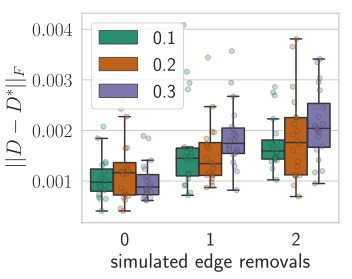

In [119]:
sns.boxplot(data=df_sims_sum[(df_sims_sum["true-k"]<=2) & (df_sims_sum["m"]<=7)& (df_sims_sum["m"]>=5)],
            x="true-k", y="frob-D", hue="eps",
            hue_order = [0.1,0.2,0.3], showfliers=False,
            palette = sns.color_palette("Dark2")
           )
g = sns.stripplot(data=df_sims_sum[(df_sims_sum["true-k"]<=2) & (df_sims_sum["m"]<=7)& (df_sims_sum["m"]>=5)],
                  x="true-k", y="frob-D", hue="eps",
                  hue_order = [0.1,0.2,0.3], split=True, jitter=0.15, alpha=.3, lw=1,
                  palette = sns.color_palette("Dark2")
                 )
handles, labels = g.get_legend_handles_labels()
g.legend(handles[0:3], labels[0:3])
g.set_ylabel("$||D-D^*||_F$")
g.set_xlabel("simulated edge removals")
plt.gcf().set_size_inches(5, 4)
plt.tight_layout()
plt.savefig("sims_D.pdf")

/Users/melkebir/anaconda2/lib/python2.7/site-packages/seaborn/categorical.py:2775: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)


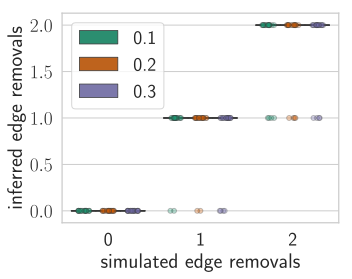

In [120]:
sns.boxplot(data=df_sims_sum[(df_sims_sum["true-k"]<=2) & (df_sims_sum["m"]<=7)& (df_sims_sum["m"]>=5)], 
            x="true-k", y="inf-k", hue="eps",
            hue_order = [0.1,0.2,0.3], showfliers=False,
            palette = sns.color_palette("Dark2")
           )
g = sns.stripplot(data=df_sims_sum[(df_sims_sum["true-k"]<=2) & (df_sims_sum["m"]<=7)& (df_sims_sum["m"]>=5)], 
            x="true-k", y="inf-k", hue="eps",
            hue_order = [0.1,0.2,0.3], split=True, jitter=0.2, alpha=.3, lw=1,
            palette = sns.color_palette("Dark2")
           )
handles, labels = g.get_legend_handles_labels()
g.legend(handles[0:3], labels[0:3])
g.set_ylabel("inferred edge removals")
g.set_xlabel("simulated edge removals")
# g.set_xticklabels(["$0$ $[0]$", "$1$ $[1]$", "$2$ $[2]$"])
plt.gcf().set_size_inches(5, 4)
plt.tight_layout()
plt.savefig("sims_k.pdf")

In [121]:
df_sims_sum['correct-subtree-recall'] = df_sims_sum['correct-subtrees'] / (df_sims_sum['true-k']+1)

/Users/melkebir/anaconda2/lib/python2.7/site-packages/seaborn/categorical.py:2775: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)


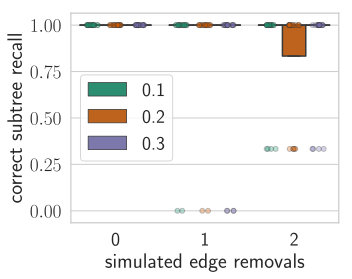

In [122]:
sns.boxplot(data=df_sims_sum[(df_sims_sum["true-k"]<=2) & (df_sims_sum["m"]<=7)& (df_sims_sum["m"]>=5)], 
            x="true-k", y="correct-subtree-recall", hue="eps",
            hue_order = [0.1,0.2,0.3], showfliers=False,
            palette = sns.color_palette("Dark2")
           )
g = sns.stripplot(data=df_sims_sum[(df_sims_sum["true-k"]<=2) & (df_sims_sum["m"]<=7)& (df_sims_sum["m"]>=5)], 
            x="true-k", y="correct-subtree-recall", hue="eps",
            hue_order = [0.1,0.2,0.3], split=True, jitter=0.2, alpha=.3, lw=1,
            palette = sns.color_palette("Dark2")
           )
handles, labels = g.get_legend_handles_labels()
g.legend(handles[0:3], labels[0:3])
g.set_ylabel("correct subtree recall")
g.set_xlabel("simulated edge removals")
# g.set_xticklabels(["$0$ $[0]$", "$1$ $[1]$", "$2$ $[2]$"])
plt.gcf().set_size_inches(5, 4)
plt.tight_layout()
plt.savefig("sims_recall.pdf")

In [27]:
df_sims_sum[(df_sims_sum["true-k"]<=2) & (df_sims_sum["m"]<=7)& (df_sims_sum["m"]>=5)]

,instance,m,true-k,eps,inf-k,frob-D,L1-D,Linf-D,correct-subtrees,diff-k,correct-subtree-recall
3,m5_S18_k0_eps0.0.P_eps.txt,5,0,0.0,0,0.001875,0.002895,0.338500,1,0,1.000000
6,m5_S37_k0_eps0.2.P_eps.txt,5,0,0.2,0,0.001842,0.002555,0.422172,1,0,1.000000
7,m7_S49_k2_eps0.2.P_eps.txt,7,2,0.2,2,0.001213,0.002135,0.364182,3,0,1.000000
8,m5_S62_k2_eps0.2.P_eps.txt,5,2,0.2,2,0.001948,0.005694,0.209626,3,0,1.000000
9,m7_S49_k2_eps0.1.P_eps.txt,7,2,0.1,1,0.002577,0.008228,0.366740,1,1,0.333333
12,m5_S66_k1_eps0.1.P_eps.txt,5,1,0.1,1,0.000951,0.002237,0.125893,2,0,1.000000
13,m7_S43_k2_eps0.3.P_eps.txt,7,2,0.3,2,0.001415,0.003002,0.250660,3,0,1.000000
16,m7_S49_k0_eps0.2.P_eps.txt,7,0,0.2,0,0.001313,0.001598,0.557439,1,0,1.000000
18,m5_S66_k0_eps0.3.P_eps.txt,5,0,0.3,0,0.001761,0.002670,0.311055,1,0,1.000000
19,m7_S12_k2_eps0.2.P_eps.txt,7,2,0.2,2,0.001829,0.002204,0.450255,3,0,1.000000
